In [1]:
from esda_modularized_functions import *

In [164]:
# read afgifte feather 
df = pd.read_feather('../data/lma/af_2019-2020_valid.feather')
df = df[['eaPostcode', 'mat', 'matDesc', 'sbiSec', 'sbiSecDesc', 'kg']]
df.eaPostcode = df.eaPostcode.str[:4]
df.rename(columns={'eaPostcode': 'pc'}, inplace=True)

# read pc, add geometry
pc = gpd.read_file('../data/spatial-data/nl_pc4_amersfoort.shp')
df = pd.merge(df, pc, on='pc', how='left')
df = gpd.GeoDataFrame(df)

# read spatial weights
wq = lp.weights.Queen.from_file('../data/spatial_weights/wq_pc4.gal')
wq_ni = lp.weights.Queen.from_file('../data/spatial_weights/wq_noislands_pc4.gal')
pcIslands = list(pc.iloc[wq.islands].pc)
pc_noIslands = pc[~pc.pc.isin(pcIslands)]
wds = dict()
for i in ['4', '10', '30']: 
    wds['wd{}'.format(i)] = lp.weights.W.from_file('../data/spatial_weights/wd{}_pc4.gal'.format(i))

# Material vs Industry categorizations, zero values

In [170]:
miDfMat = calc_morans(flowType='mat', top=dfMatList, df=df, pc=pc, wq=wq, log=False, plot=False)

('WARNING: ', '3478', ' is an island (no neighbors)')
('WARNING: ', '3611', ' is an island (no neighbors)')


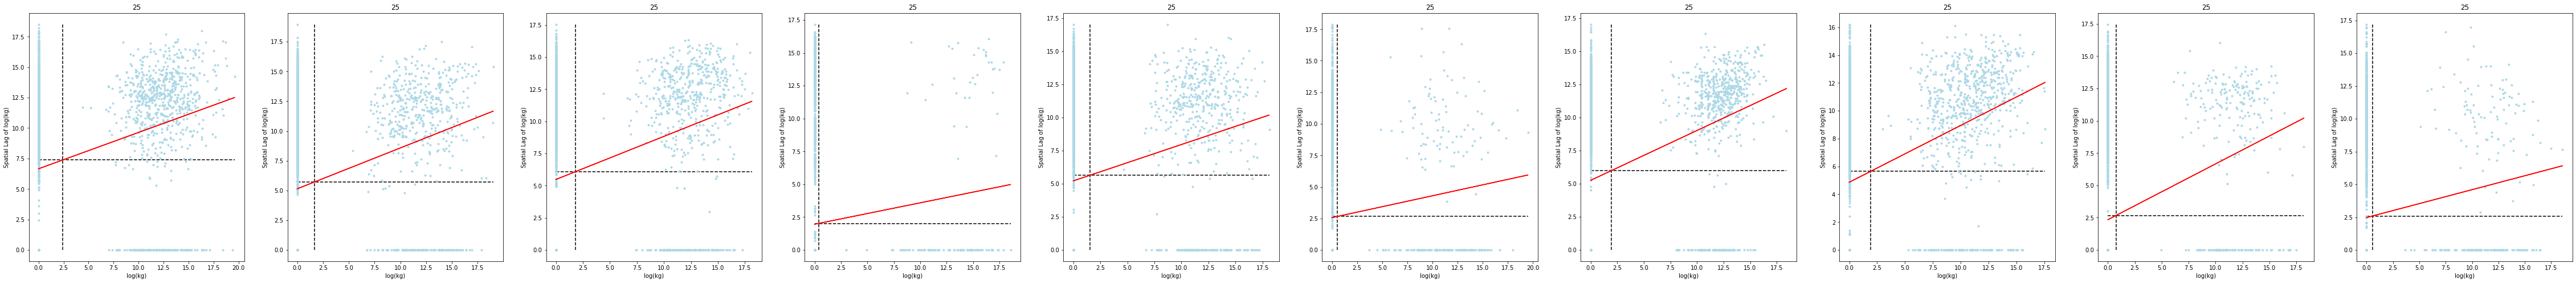

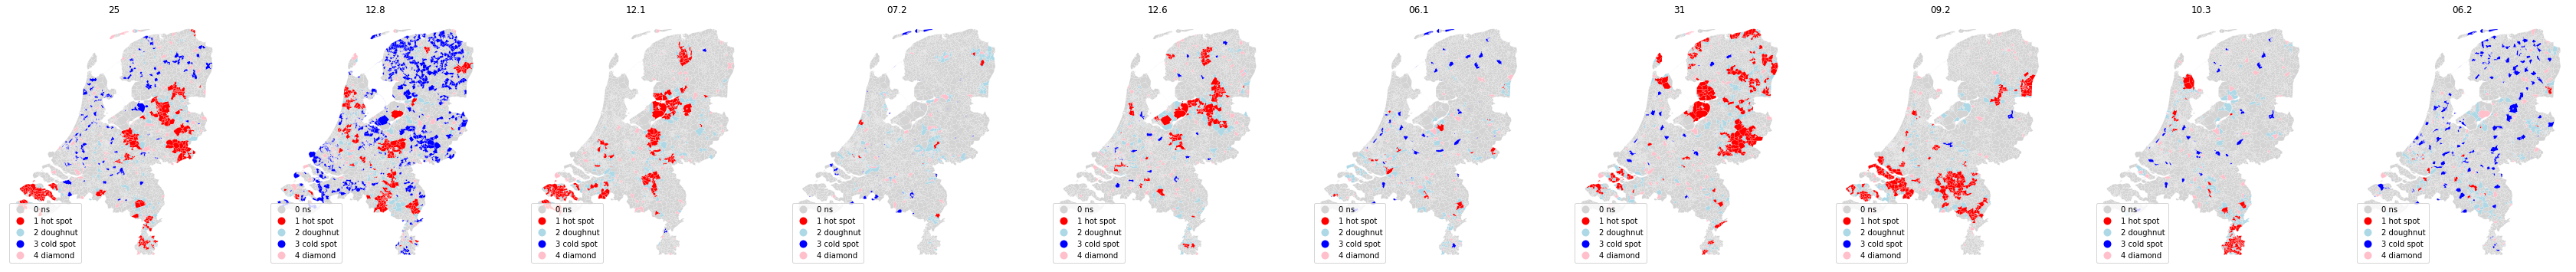

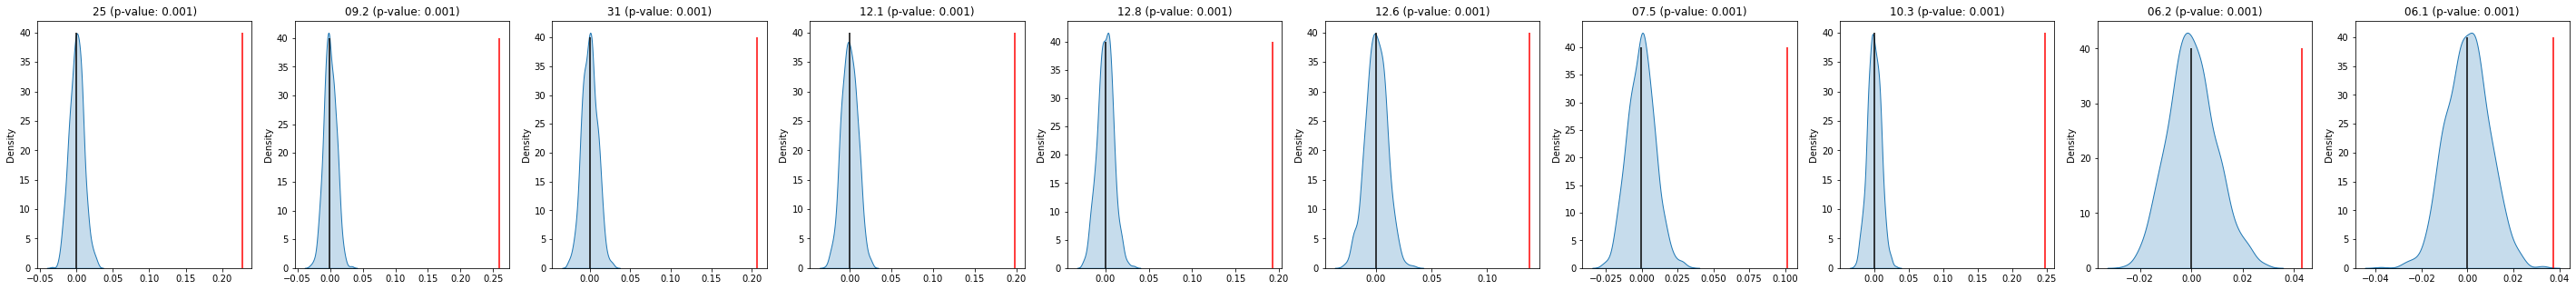

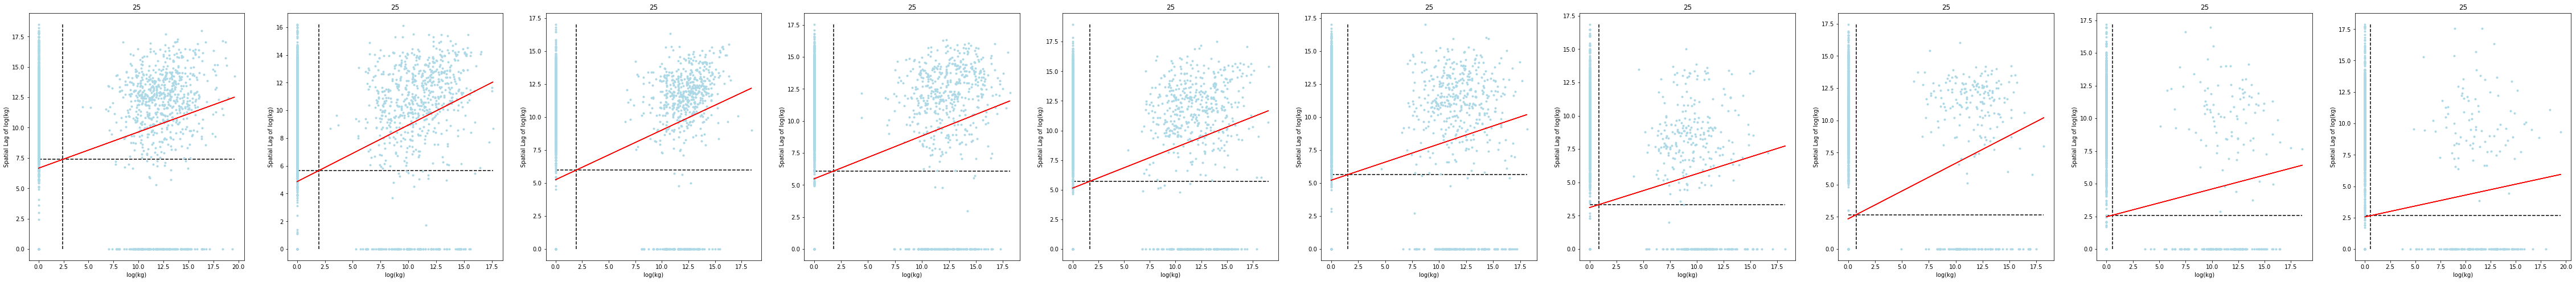

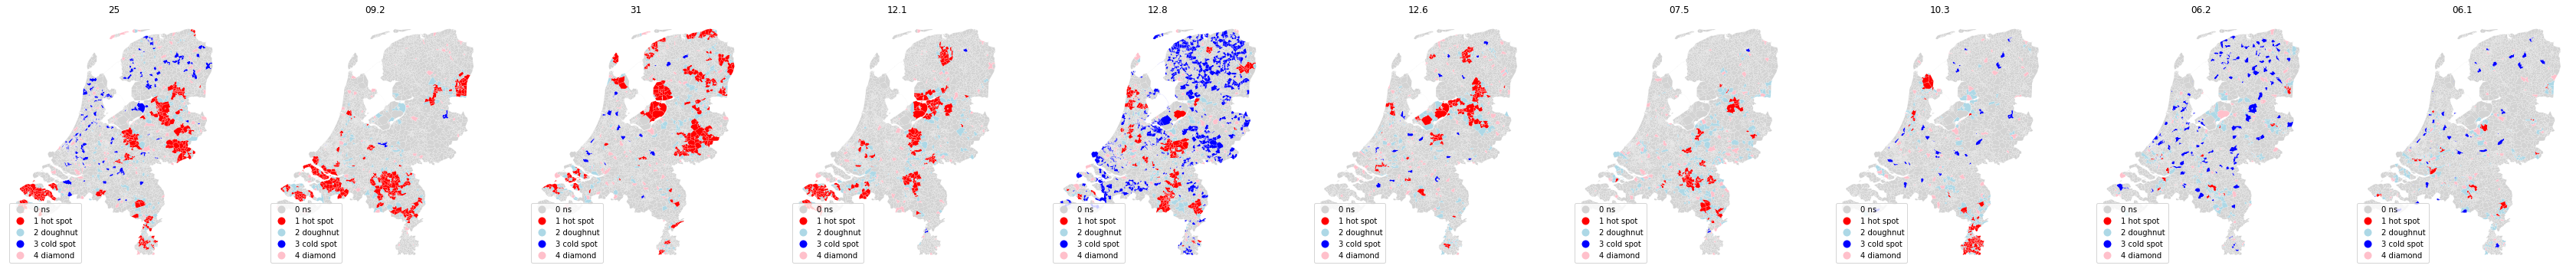

['07.2', '07.5']


In [3]:
dfMat = extract_top_weight(df, flowType='mat', topn=10, plot=False)
dfMatList = [i for i in dfMat.mat]
miDfMat = calc_morans(flowType='mat', top=dfMatList, df=df, pc=pc, wq=wq, plot=True)
morans_plot(dftop10=dfMat, df=df, pc=pc, wq=wq)
plot_hcdd(dftop=dfMat, df=df, pc=pc_noIslands, wq=wq_ni)

dfMat_geo = extract_top_geo(df, pc=pc, flowType='mat', topn=10, plot=False)
dfMatList_geo = [i for i in dfMat_geo.mat]
miDfMat_geo = calc_morans(flowType='mat', top=dfMatList_geo, df=df, pc=pc, wq=wq, plot=True)
morans_plot(dftop10=dfMat_geo, df=df, pc=pc, wq=wq)
plot_hcdd(dftop=dfMat_geo, df=df, pc=pc_noIslands, wq=wq_ni)

print(list(set(dfMatList) - set(dfMatList_geo)) + list(set(dfMatList_geo) - set(dfMatList)))

In [187]:
miDfMat.drop(columns=['mi', 'mi_sims']).sort_values(by='percZero').style.apply(highlight_function, subset=['mi_obs', 'p_values'], axis=1)

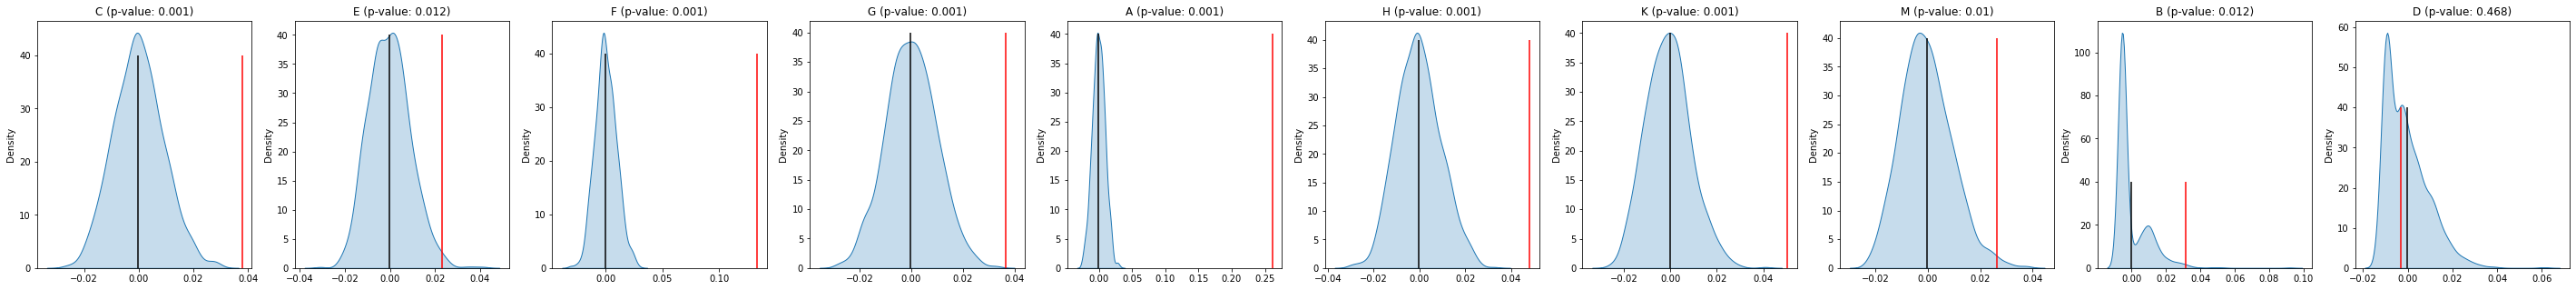

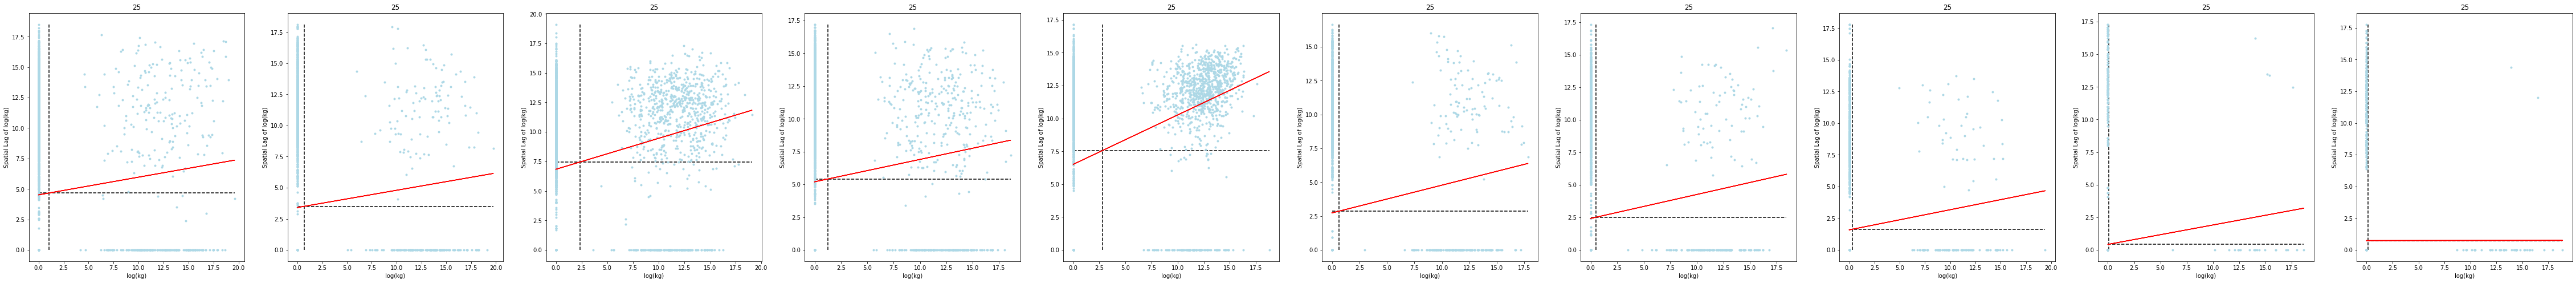

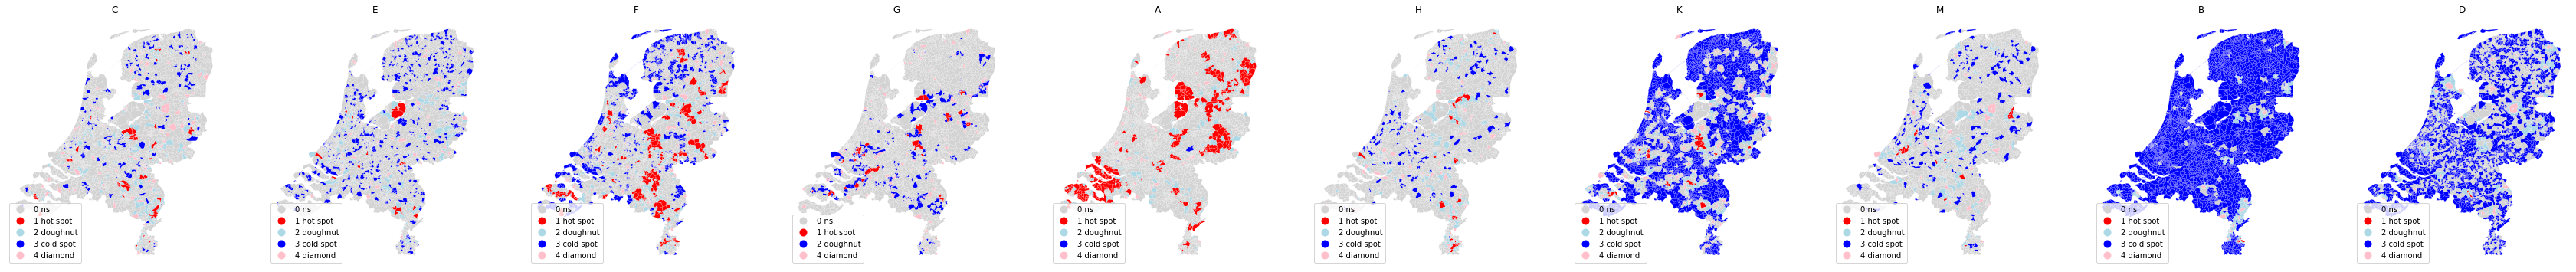

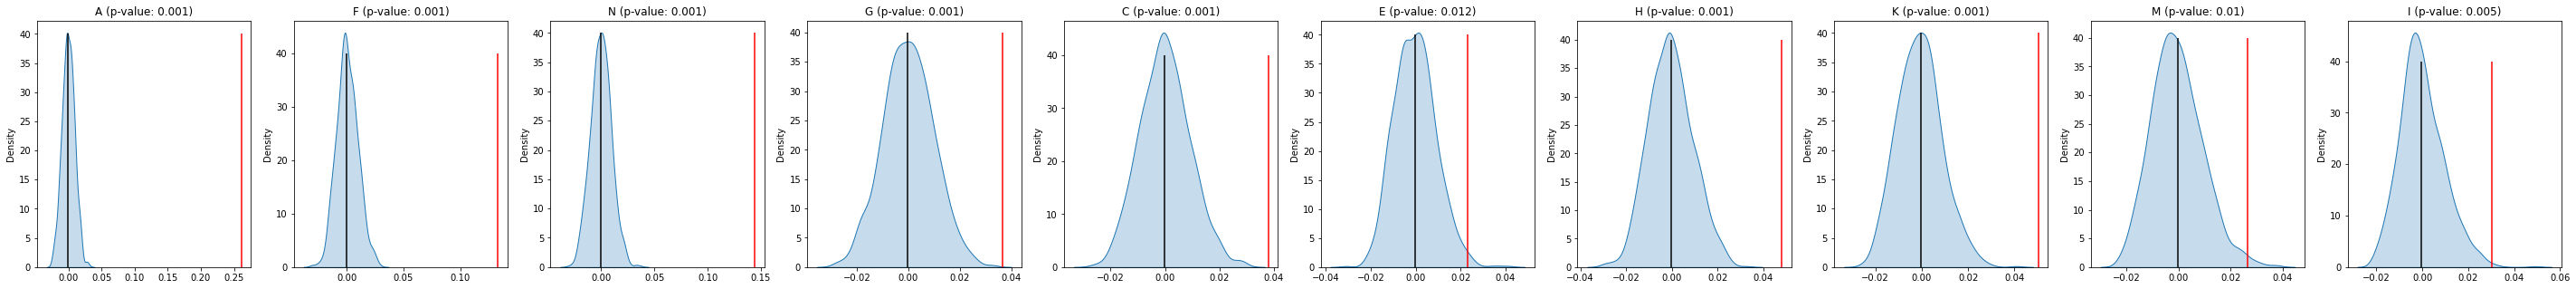

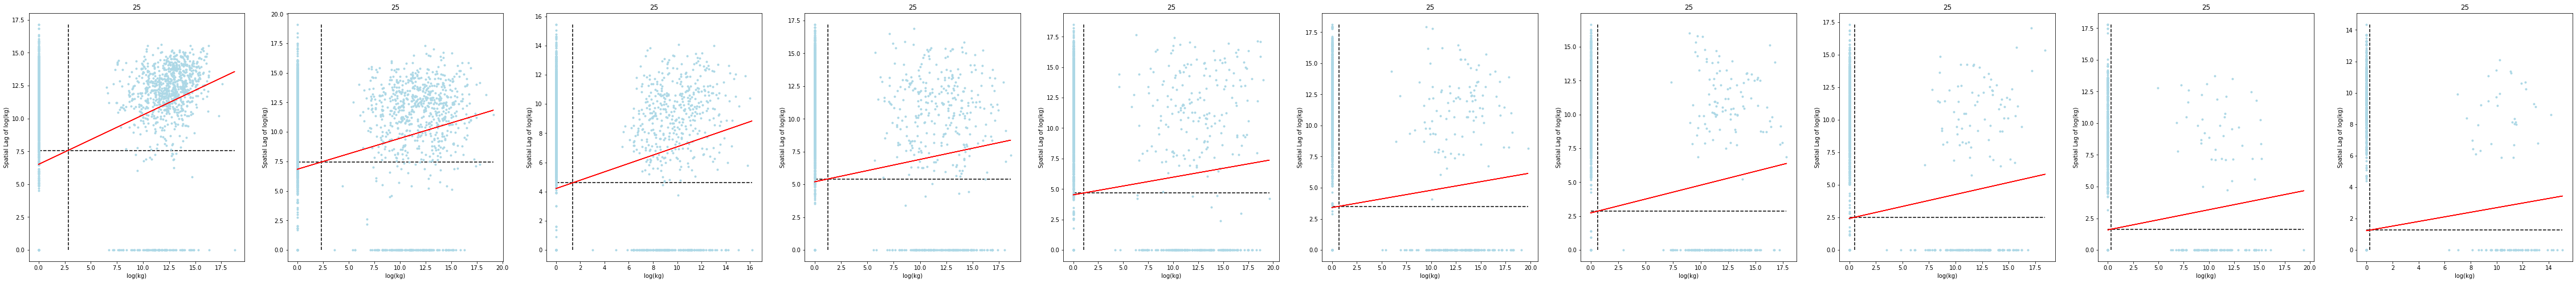

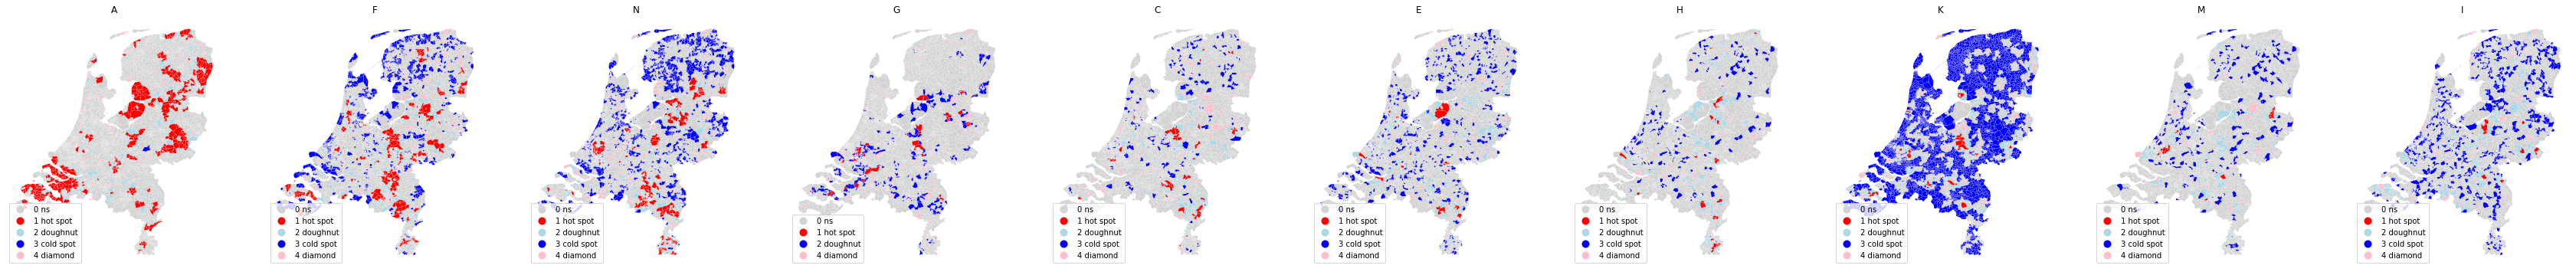

['D', 'B', 'N', 'I']


In [4]:
dfInd = extract_top_weight(df, flowType='sbiSec', topn=10, plot=False)
dfIndList = [i for i in dfInd.sbiSec]
miDfInd = calc_morans(flowType='sbiSec', top=dfIndList, df=df, pc=pc, wq=wq, plot=True)
morans_plot(dftop10=dfInd, df=df, pc=pc, wq=wq)
plot_hcdd(dftop=dfInd, df=df, pc=pc_noIslands, wq=wq_ni)

dfInd_geo = extract_top_geo(df=df, pc=pc, flowType='sbiSec', topn=10, plot=False)
dfIndList_geo = [i for i in dfInd_geo.sbiSec]
miDfInd_geo = calc_morans(flowType='sbiSec', top=dfIndList_geo, df=df, pc=pc, wq=wq, plot=True)
morans_plot(dftop10=dfInd_geo, df=df, pc=pc, wq=wq)
plot_hcdd(dftop=dfInd_geo, df=df, pc=pc_noIslands, wq=wq_ni)

print(list(set(dfIndList) - set(dfIndList_geo)) + list(set(dfIndList_geo) - set(dfIndList)))

In [189]:
miDfInd.drop(columns=['mi', 'mi_sims']).sort_values(by='percZero').style.apply(highlight_function, subset=['mi_obs', 'p_values'], axis=1)

The cells above show the Moran's I results for the top 10 materials by weight and by geographical spread. 'Geographical spread' is defined by the percentage of postcodes that receive this type of material. 

#### Difference between weight versus geographical spread; material vs industry categorization 
For material categorization, there isn't a big difference between top 10 materials by weight versus by geographical spread. The differences are: 
* 06.1 (metallic wastes) was higher-up in the ranking for weight than for geographical spread. This means that there are a lot of these materials received, but these receivers are concentrated in a few locations. 
* 07.2 (paper and cardboard) showed up in the top 10 materials by weight, but not for by geographical spread. Instead, 07.5 (wood wastes) took its place. This also probably means that, although there is a lot of kgs of paper and cardboard, it's only received by a few locations. On the other hand, there are less kgs of wood wastes, but they are more spread out geographically. 

For industry categorization, there seem to be more differences: 
* Sectors B (mining of materials) and D (Production, distribution and trade in electricity, natural gas, steam and cooled air) showed up in top 10 by weight, but were replaced by N (Rental of movable property and other business services) and I (Lodging, meal and beverage provision) for top 10 by geographical spread. 

#### Effect of zero values / geographical spread on Moran's I results
When looking at the top 10 materials by weight, we can see that the level of clustering is not entirely related to weight. For example, the fourth largest material type, 07.2 (paper and cardboard wastes), isn't significantly clustered. From this result, we might claim that cardboard receivers are randomly distributed through the Netherlands, and that their location doesn't follow any spatial patterns. However, this is not the full story. If we look at the top 10 materials by geographical spread, we can wee a clear pattern for all the plots. For the kde plots, we can see that, look from left to right, the red line gets closer to the blue curve. Looking at the Moran's scatter plots from left to right, we see that the red line gets flatter, and the blue dots get fewer and more scattered. As for the hcdd plots, the hotspots are much larger on the left than on the right. 

Clearly, the amount of 'spatial clustering' calculated from Moran's I is very much related to the number of zero values in the dataset. The more zero values a material has, the less likely it will be significantly spatially clustered. This makes sense, and can be illustrated with an extreme example. Say that material 'A' is only received by 2 postcodes out of ~4000. It would be very difficult to answer the question, 'how likely is material 'A' randomly distributed through space?' Even if the two postcodes were right next to each other, we can't confidently say that the locations of material 'A' is not random. On the other hand, let's say that material 'B' is received by all 4000 post codes, but some postcodes receive a lot while others receive less. If all the high values for material 'B' are next to each other, we can more confidently say that material 'B' is following a spatial pattern, because it's highly unlikely that 3000 postcodes arranged themselves in clusters randomly. 

## Limitations - what can and can't we conclude from the results? 
* difficult to say that material categorization is better than industry categorization
    * more flows in material than in industry, cannot compare. 
    * even if using the same flows, need to check if there are roughly the same amount of categorizations of material vs industry, and that each categorization has roughly same kg...?
* what global and local Moran's I says about spatial clustering / patterns 
    * cannot say industry 'A' is more clustered than industry 'B', because they have vastly different amounts of zero values. Can only say 'A' has less zero values than 'B'. Can also say that these flows follow spatial pattern and those flows don't? 
    * hotspots probably make sense for flows that have a higher geographical spread (and are significantly clustered) 
    * Moran's I values seem low (ranging from 0 to 0.26) compared to paper on gdp per capita, which has Moran's I values of 0.6 (Gallo and Ertur 2005). But other studies (Messner et al. 1999, Anselin et al. 2007) show lower Moran's I values, more similar to ours. 
* some industry categorizations don't really make sense - why is there mining? or distribution of energy? 

## Next steps 
* data cleaning / sorting
    * closer examination of flows - are categorization of material vs industry roughly the same? e.g. do top 3 industry and top 3 materials have roughly the same amount (kg)? Are there roughly the same number of categorizations for mat versus ind? 
    * aggregate data to 2-digit postcode (n=90) instead of 4-digit postcode (n=4000)? Will probably result in a lot less zero values. Other ESDA studies (Gallo and Ertur 2005, Messner et al. 1999, Anselin et al. 2007) have a lot less datapoints. Looking at the maps, looks no more than 100. We are currently doing 4000. Probably too much / too complicated? 
    * combine ESV and GNC? 
* method
    * binary Moran's I? 
    * different spatial weights (currently using queen weights, but can also use rook, nearest neighbors, distance...etc) See Anselin et al. 2007 for example 

# Trying different spatial weights, log transformation

In [5]:
%%time
# trying differen wds 
midfs = []
for i in [True, False]: 
    midf = calc_morans(flowType='mat', top=['25', '06.1'], df=df, pc=pc, log=i, wq=wq, plot=False)
    midf['wd'] = 'wq'
    midfs.append(midf)
    for k, v in wds.items(): 
        midf = calc_morans(flowType='mat', top=['25', '06.1'], df=df, pc=pc, log=i, wq=v, plot=False)
        midf['wd'] = k
        midfs.append(midf)
midf_all = pd.concat(midfs)

('WARNING: ', '99', ' is an island (no neighbors)')
('WARNING: ', '373', ' is an island (no neighbors)')
('WARNING: ', '374', ' is an island (no neighbors)')
('WARNING: ', '375', ' is an island (no neighbors)')
('WARNING: ', '376', ' is an island (no neighbors)')
('WARNING: ', '377', ' is an island (no neighbors)')
('WARNING: ', '391', ' is an island (no neighbors)')
('WARNING: ', '392', ' is an island (no neighbors)')
('WARNING: ', '393', ' is an island (no neighbors)')
('WARNING: ', '632', ' is an island (no neighbors)')
('WARNING: ', '946', ' is an island (no neighbors)')
('WARNING: ', '969', ' is an island (no neighbors)')
('WARNING: ', '971', ' is an island (no neighbors)')
('WARNING: ', '976', ' is an island (no neighbors)')
('WARNING: ', '981', ' is an island (no neighbors)')
('WARNING: ', '982', ' is an island (no neighbors)')
('WARNING: ', '983', ' is an island (no neighbors)')
('WARNING: ', '984', ' is an island (no neighbors)')
('WARNING: ', '993', ' is an island (no neighbo

In [6]:
midf_all[(midf_all.mat == '25')].sort_values(by='mi_obs', ascending=False)

mat                                               mi    mi_obs  mi_sims_av  \
0  25  <esda.moran.Moran object at 0x00000180F6204E50>  0.227442   -0.000246   
0  25  <esda.moran.Moran object at 0x00000180886F7FD0>  0.185850   -0.000246   
0  25  <esda.moran.Moran object at 0x00000180885B8F70>  0.178034   -0.000246   
0  25  <esda.moran.Moran object at 0x00000180887FEDC0>  0.105917   -0.000246   
0  25  <esda.moran.Moran object at 0x00000180FADE20A0>  0.027788   -0.000246   
0  25  <esda.moran.Moran object at 0x0000018081B04670>  0.007898   -0.000246   
0  25  <esda.moran.Moran object at 0x0000018081B048B0>  0.001856   -0.000246   
0  25  <esda.moran.Moran object at 0x0000018081B04280>  0.000665   -0.000246   

                                             mi_sims  p_values    log    wd  
0  [2.34777305819209e-05, -0.0067363189745663085,...     0.001   True    wq  
0  [0.012742823928832702, -0.0033637029756040542,...     0.001   True   wd4  
0  [0.00642059616225759, -0.0011179369100090145, ...     0.001   True  wd10  
0  [0.0005655423816903215, -0.0006009261771142436...     0.001   True  wd30  
0  [0.0012804889817770912, -0.0009646802541787186...     0.021  False    wq  
0  [0.0026329760816916443, -0.005813431335251294,...     0.072  False   wd4  
0  [0.0013232332317772587, -0.0015889114763138893...     0.184  False  wd10  
0  [0.00048704196500383597, -0.001053250566423585...     0.199  False  wd30

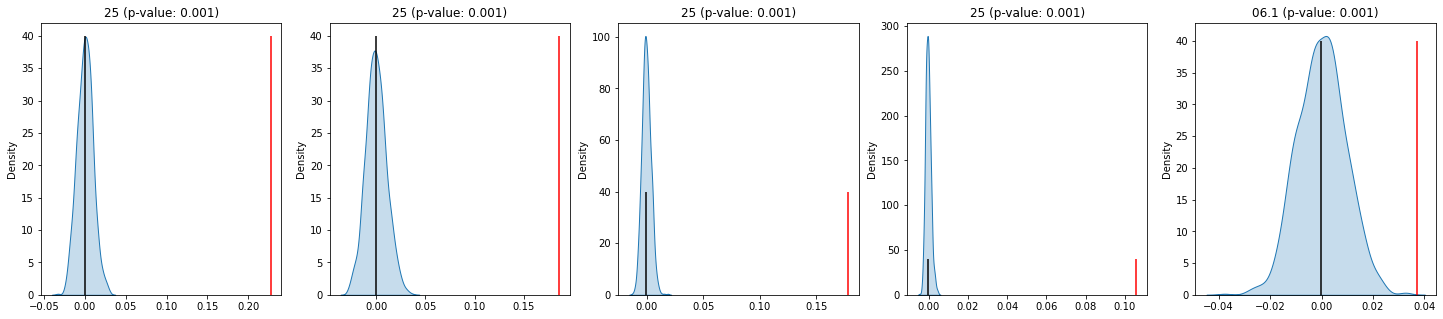

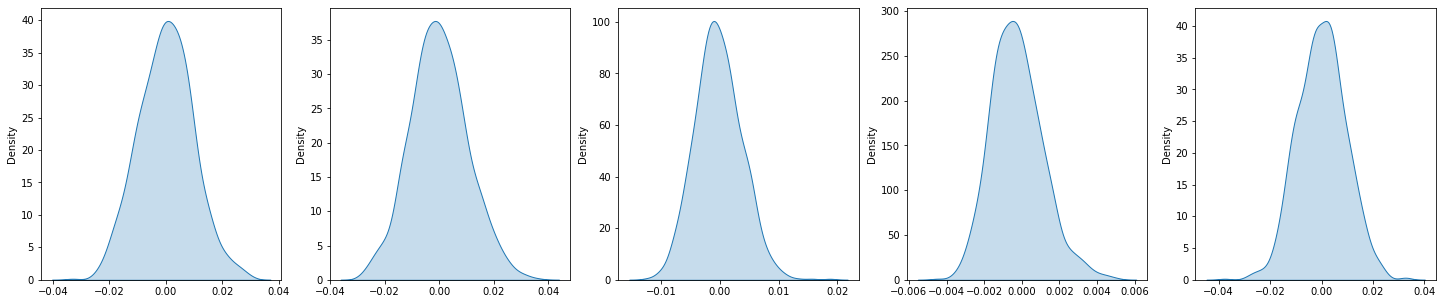

In [9]:
plot = midf_all[midf_all.log == True].sort_values(by='mi_obs', ascending=False).head().reset_index(drop=True)

fig, ax = plt.subplots(1,len(plot), figsize=(5*len(plot), 5))
def plotMi(row): 
    i = row.name
    sn.kdeplot(row.mi_sims, shade=True, ax=ax[i])
    ax[i].vlines(row.mi_obs, 0, 40, color='r')
    ax[i].vlines(row.mi_sims_av, 0, 40)
    ax[i].set_title("{} (p-value: {})".format(row['mat'], row.p_values))
plot.apply(lambda row: plotMi(row), axis=1)
plt.show()

fig, ax = plt.subplots(1,len(plot), figsize=(5*len(plot), 5))
def plotMi(row): 
    i = row.name
    sn.kdeplot(row.mi_sims, shade=True, ax=ax[i])
plot.apply(lambda row: plotMi(row), axis=1)
plt.show()

In [10]:
test = midf_all[(midf_all.mat == '25') & (midf_all.log == True)].reset_index(drop=True)
print(test.loc[0,'p_values'])
print(test.loc[3,'p_values'])

0.001
0.001


* log-transformed values yield higher Moran's Is, but I'm not sure if that's "allowed". Moran's I calculation includes calculating the mean, and perhaps calculating the mean of log-transformed values doesn't make sense?
    * if log-transformation is "not allowed", then almost all p-values are too high... (> 0.05)
    * However, [Huo et al. 2012](https://pdfs.semanticscholar.org/5e95/4c17074d1d65278388e8d4757c7153c40095.pdf) calculated Moran's I using log-transformed values, see bottom of page 7. It has 73 citations according to google scholar.
* moran's I decreases as wd increases. This is strange because I expected the opposite.
    * the bigger the neighborhood, the less the clustering 
* another strange thing is the mi_sim_av (average Moran's I of permutations) is the same for all rows. This shouldn't be the case.
    * looking at the monte carlo plots, it seems like the mi_sim_av is the same, but the Moran's I of the individual permulations are different (blue curves are different sizes and shapes). 
    * seems like increasing the weight distances decreases the observed moran's I, but also decreases the p-value? (red line is further away from blue curve)

# Trying Moran's I for PC2 data

In [38]:
# read pc and wq at pc2 level
pc2 = gpd.read_file('../data/spatial-data/nl_pc2_amersfoort.shp')
wqPc2 = lp.weights.W.from_file('../data/spatial_weights/wq_pc2.gal')

# make pc2_noIslands and wqPc2_noIslands
pc2_noIslands = pc2.drop(index=[int(i) for i in wqPc2.islands])
wqPc2_noIslands = lp.weights.W.from_file('../data/spatial_weights/wq_noislands_pc2.gal')

# make df at pc2 level
dfPc2 = df.copy()
dfPc2.pc = dfPc2.pc.str[:2]
dfPc2 = dfPc2.groupby(['pc', 'mat', 'matDesc', 'sbiSec', 'sbiSecDesc']).sum().reset_index()
dfPc2 = pd.merge(pc2, dfPc2, on='pc', how='right')

C:\Users\tpytsui\Miniconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 35.
  warnings.warn(message)


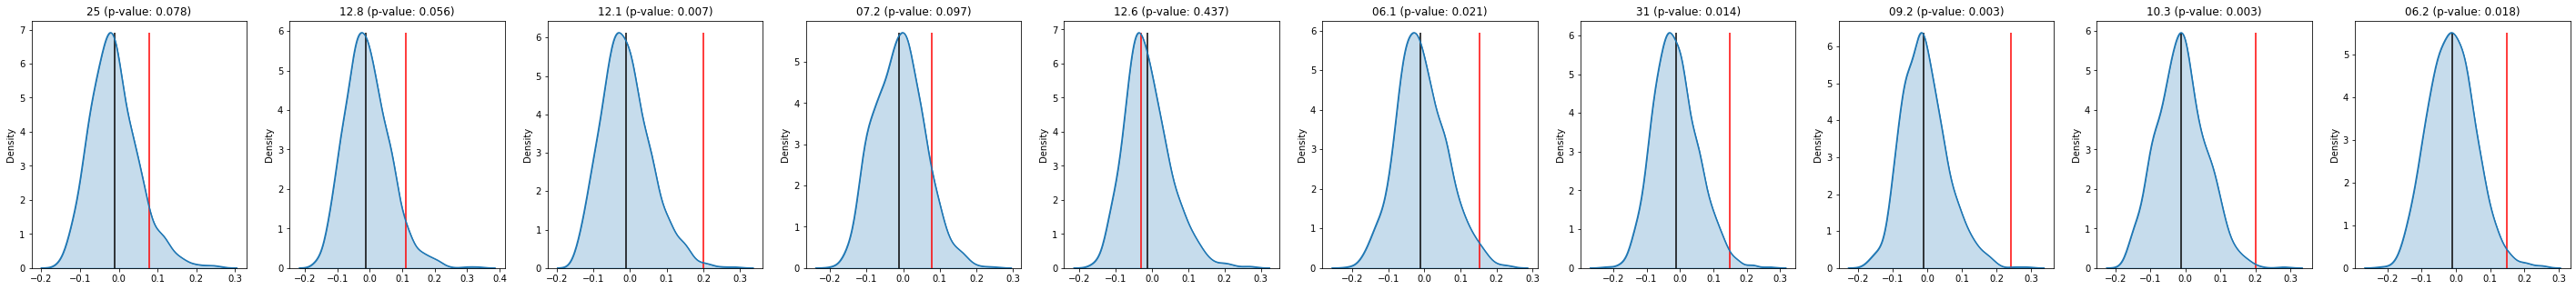

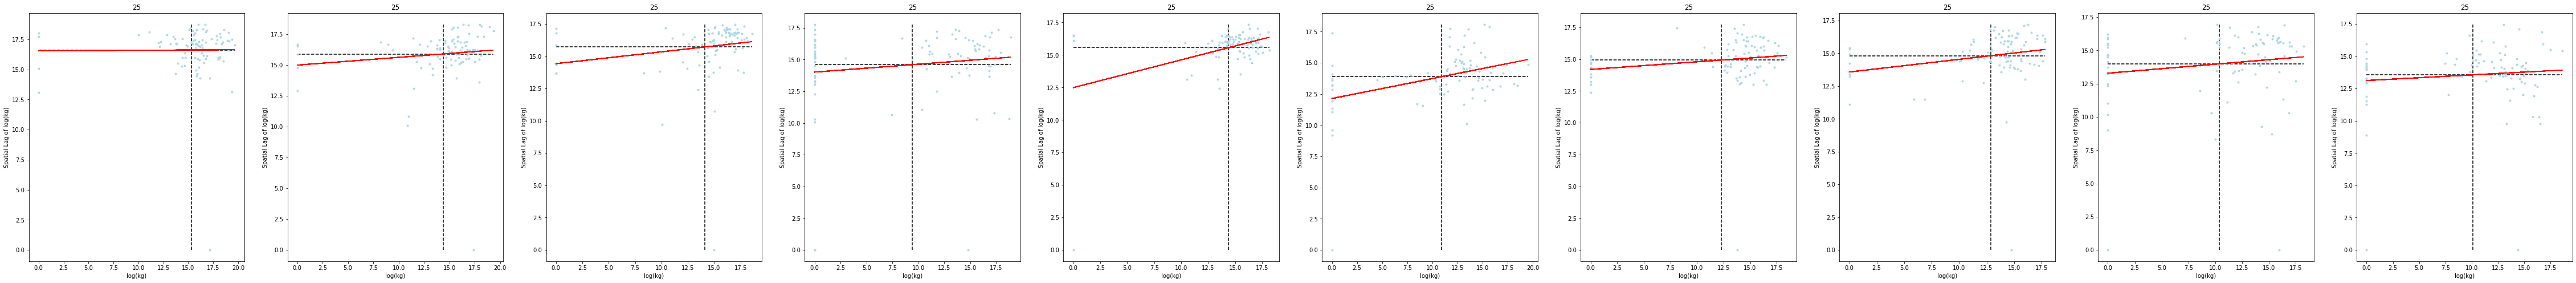

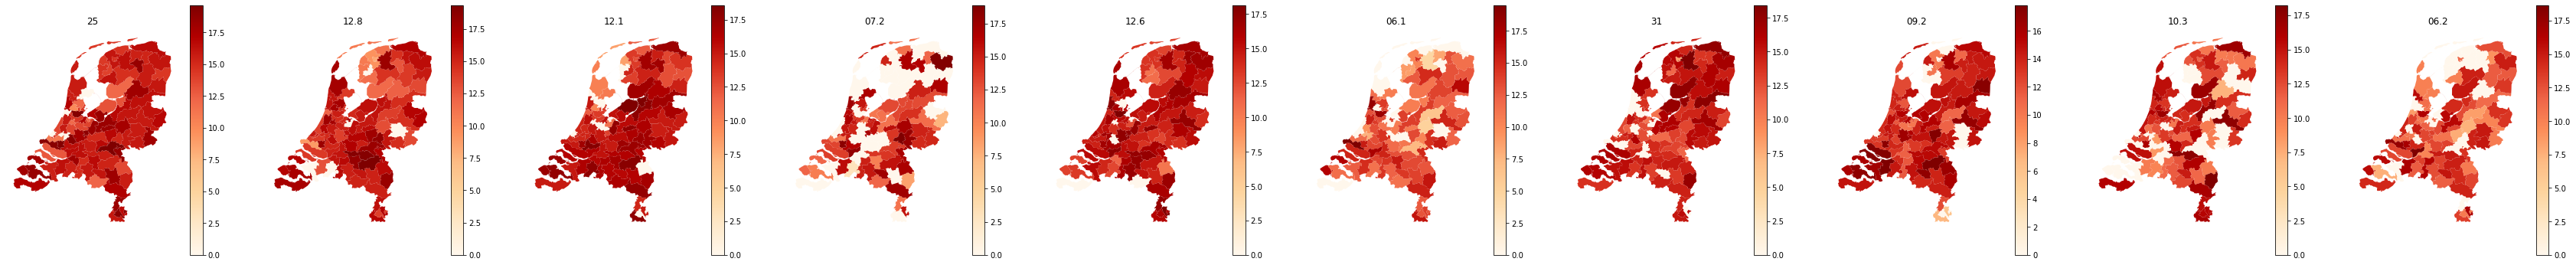

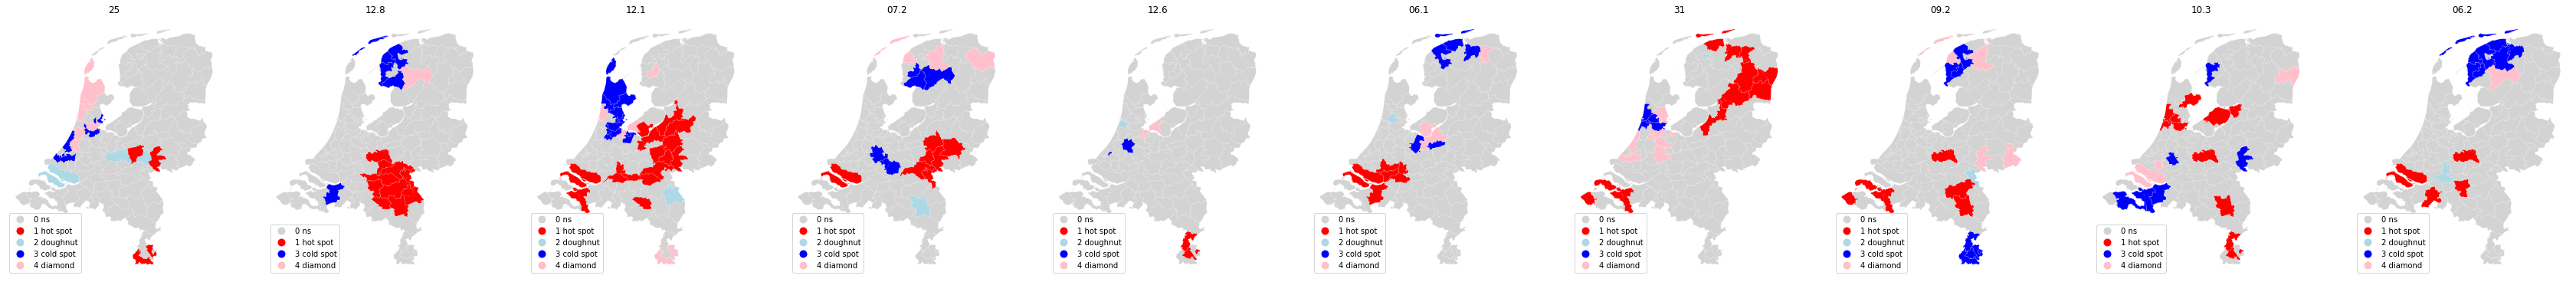

In [148]:
dfMatPc2 = extract_top_weight(dfPc2, flowType='mat', topn=10, plot=False)
dfMatListPc2 = [i for i in dfMatPc2.mat]
midfMatPc2 = calc_morans(flowType='mat', top=dfMatListPc2, df=dfPc2, pc=pc2, log=True, wq=wqPc2, plot=True)
morans_plot(dftop10=dfMatPc2, df=dfPc2, pc=pc2, wq=wqPc2)
choroPlot(dftop=dfMatPc2, df=dfPc2, pc=pc2)
plot_hcdd(dftop=dfMatPc2, df=dfPc2, pc=pc2_noIslands, wq=wqPc2_noIslands)

In [203]:
midfMatPc2.drop(columns=['mi', 'mi_sims']).sort_values(by='percZero').style.apply(highlight_function, subset=['mi_obs', 'p_values'], axis=1)

In [204]:
miDfMat.drop(columns=['mi', 'mi_sims']).sort_values(by='percZero').style.apply(highlight_function, subset=['mi_obs', 'p_values'], axis=1)

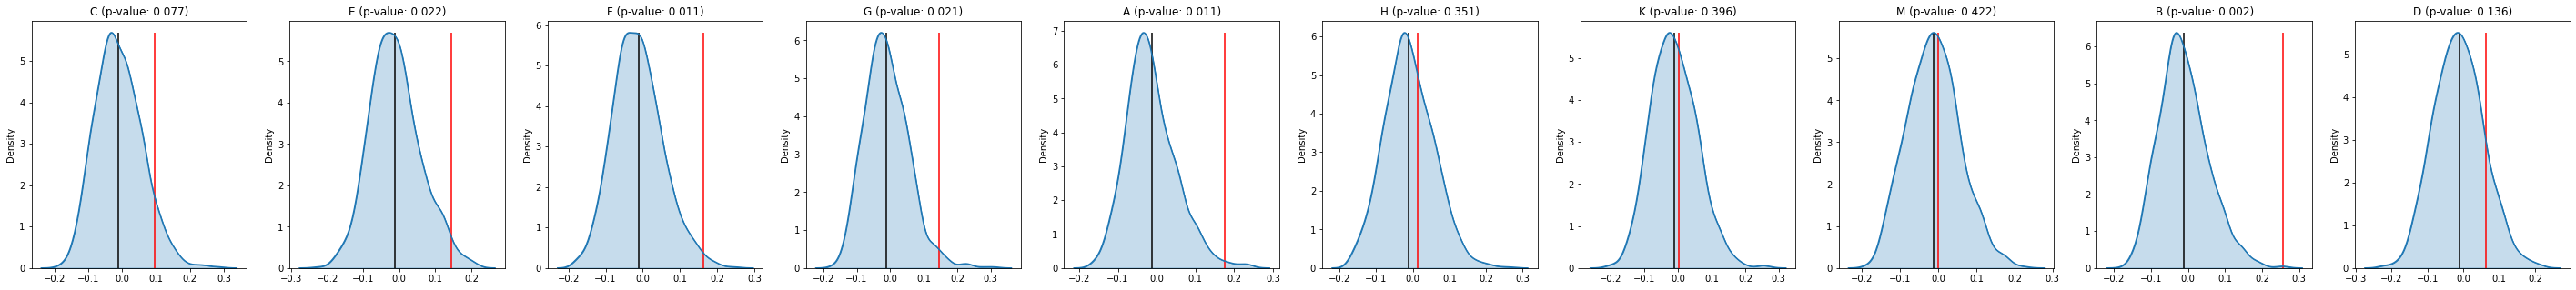

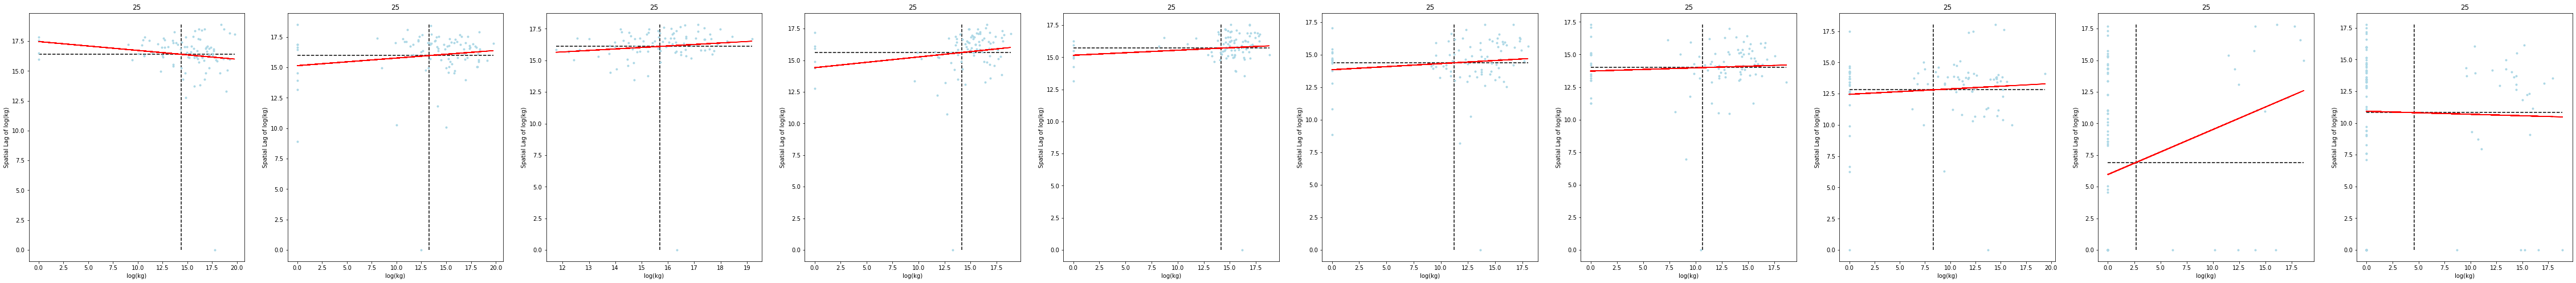

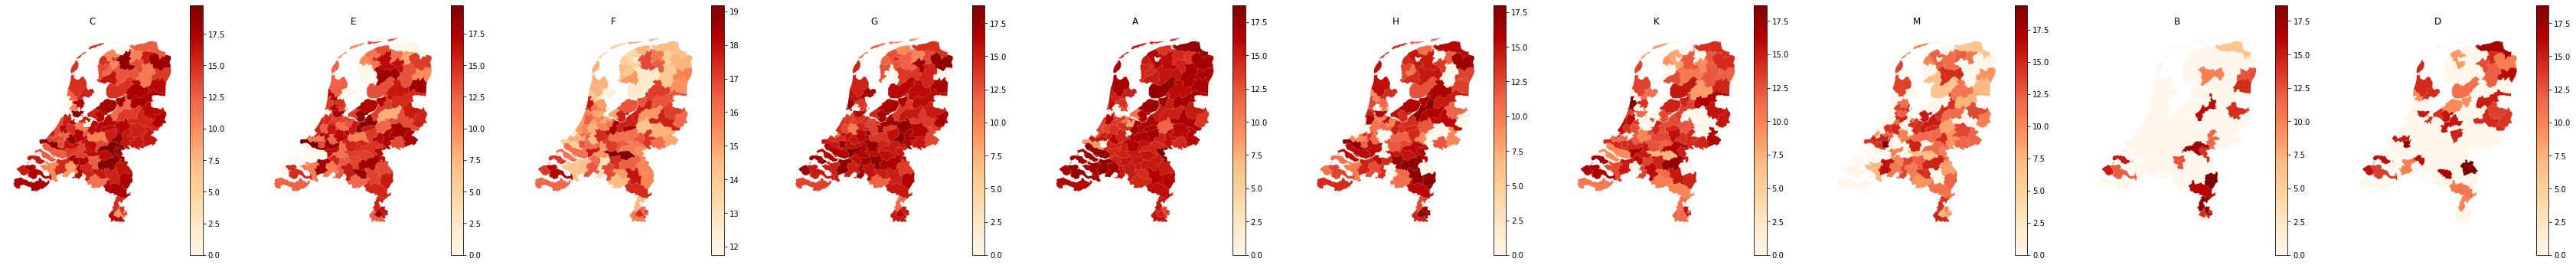

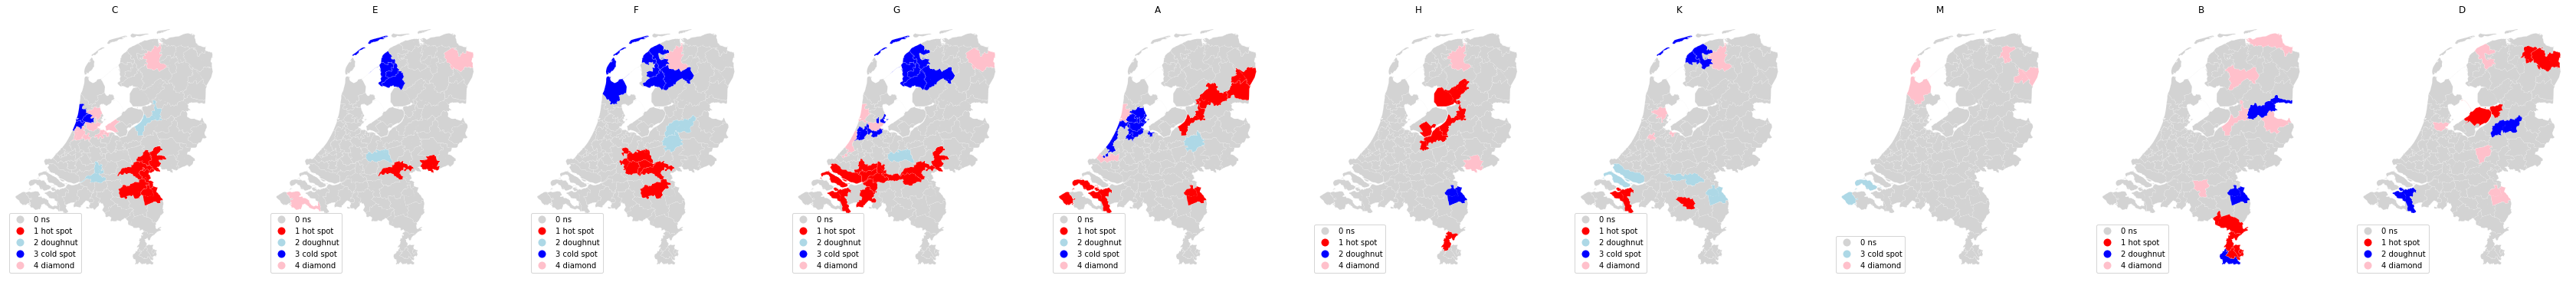

In [156]:
dfIndPc2 = extract_top_weight(dfPc2, flowType='sbiSec', topn=10, plot=False)
dfIndListPc2 = [i for i in dfIndPc2.sbiSec]
miDfIndPc2 = calc_morans(flowType='sbiSec', top=dfIndListPc2, df=dfPc2, pc=pc2, wq=wqPc2, plot=True)
morans_plot(dftop10=dfIndPc2, df=dfPc2, pc=pc2, wq=wqPc2)
choroPlot(dftop=dfIndPc2, df=dfPc2, pc=pc2)
plot_hcdd(dftop=dfIndPc2, df=dfPc2, pc=pc2_noIslands, wq=wqPc2_noIslands)

In [205]:
miDfIndPc2.drop(columns=['mi', 'mi_sims']).sort_values(by='percZero').style.apply(highlight_function, subset=['mi_obs', 'p_values'], axis=1)

In [206]:
miDfInd.drop(columns=['mi', 'mi_sims']).sort_values(by='percZero').style.apply(highlight_function, subset=['mi_obs', 'p_values'], axis=1)

* for the pc2 data, the Moran's I and p-values are less dependent on the number of zero values. Whereas in the pc4 data, the general trend is that the less zeros, the higher the Moran's I score. 
* pc2 data led to higher p-values in general, so some materials didn't past the p-test of p < 0.05. Surprisingly, the two three materials didn't pass the p-test. On the other hand, all the pc4 materials passed the p-test. This suggests that aggregating to pc2 makes the Moran's I 'stricter', so more reliable.
* for the pc2 data, almost all materials with low p-value also have a high Mi; whereas in the pc4 data, there were materials with low p-values **and** low Mi - this is especially apparent when flows were categorized by industry